In [1]:
%matplotlib ipympl
import numpy as np
from mask_utils import *
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
mask, hdmask = read_mask_bulk('wfm_mask.fits', 2, header_out=True, verbose=False)
rmatrix = read_mask_bulk('wfm_mask.fits', 3, verbose=False)
bulk = read_mask_bulk('wfm_mask.fits', 4, verbose=False)
np.sum(rmatrix)

np.float64(0.0008344650268554688)

In [3]:
#rmatrix[rmatrix < 0] = -0.33400144
#np.sum(rmatrix)

In [4]:
fx = 1
fy= 1
mask=upscale(mask, fx, fy)
bulk=upscale(bulk, fx, fy)
rmatrix = upscale(rmatrix, fx, fy)

print(mask.shape)
print(rmatrix.shape)
print(bulk.shape)

(1040, 650)
(1040, 650)
(1040, 650)


In [5]:
#Gets mask information and define X, Y vectors (centers and edges)
ELXDIM = hdmask['ELXDIM'] / fx
ELYDIM = hdmask['ELYDIM'] / fy
ELXN   = hdmask['ELXN'] * fx
ELYN   = hdmask['ELYN'] * fy

In [6]:
xedges, yedges = get_detimage_edges(ELXDIM, ELYDIM, ELXN, ELYN)

In [7]:
#Defines FITS event file
fdet = "cxb_2-50keV_10ks_infthinmask_cam1a_detected.fits"
#fdet = "catalog_noCXB_1Crab_baseline_2-50keV_1ks_cam1a_detected.fits"
#fdet = "cxb_2-50keV_10ks_cam1a_plane.fits"
#bulk = np.ones(shape(mask))

In [8]:
det, hdet0, hdet1 = read_fits_events(fdet, header0=True, header1=True, verbose=False)

In [9]:
xedges, yedges = get_detimage_edges(ELXDIM, ELYDIM, ELXN, ELYN)

In [10]:
#Computes detector image
detimage = get_detimage(det, xedges, yedges) * bulk


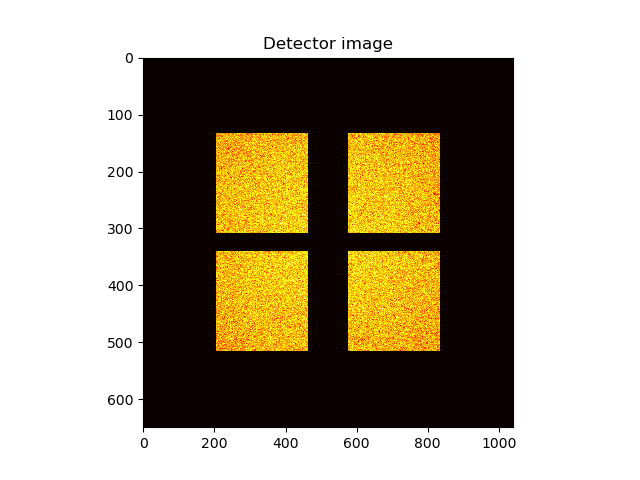

In [11]:
#Showing detimage
plt.figure()
plt.title('Detector image')
plt.imshow(detimage.T**0.5, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

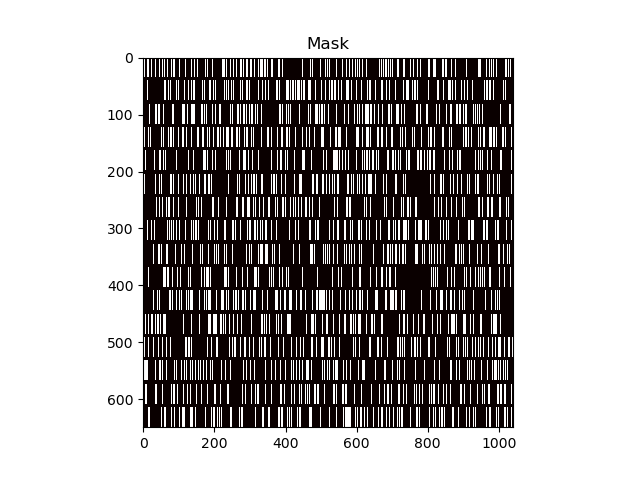

In [12]:
#Showing detimage
plt.figure()
plt.title('Mask')
plt.imshow(mask.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

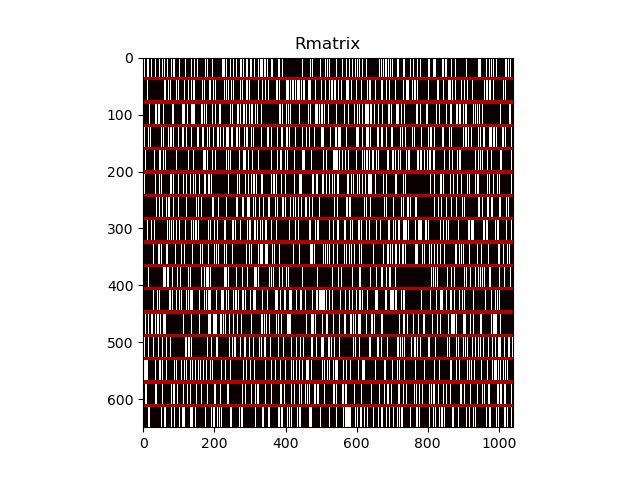

In [13]:
#Showing detimage
plt.figure()
plt.title('Rmatrix')
plt.imshow(rmatrix.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

In [14]:
#Computes balanced sky image
skyimage = decode(detimage, rmatrix, bulk)

#Finds image peak
peak = np.unravel_index(np.argmax(skyimage), skyimage.shape)

In [15]:
#Computes sky angylar coordinates
xsky, ysky = get_skycoords(skyimage, ELXDIM, ELYDIM, 202.9, verbose=True)

X bins range: -259.875 259.875
Y bins range: -259.8 259.8


In [16]:

var = correlate(np.square(rmatrix), detimage, mode="full")
var_balancing = correlate(np.square(rmatrix), bulk, mode="full") * (np.sum(detimage)) / np.square(np.sum(bulk))
var_bal = var - var_balancing 



cc = correlate(rmatrix, detimage, mode="full")
balancing = correlate(rmatrix, bulk, mode="full")
var_fra = correlate(np.square(rmatrix), detimage, mode="full")
sum_det, sum_bulk = map(np.sum, (detimage, bulk))
var_bal_fra = var_fra + np.square(balancing) * sum_det / np.square(sum_bulk) - 2 * cc * balancing / sum_bulk


center = (1039, 649)

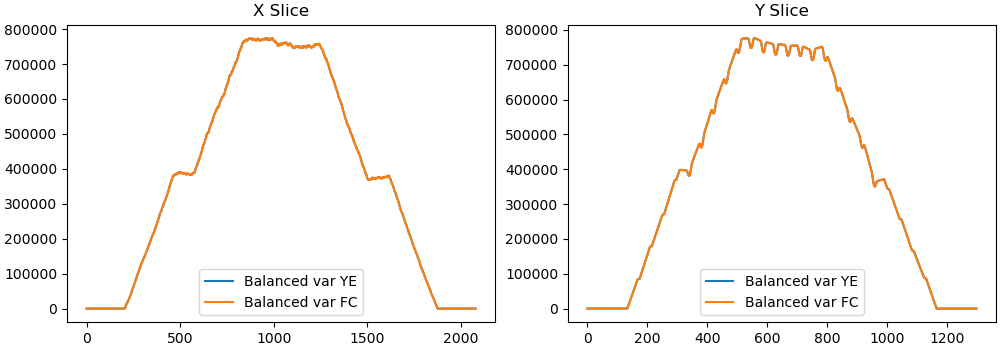

0.0001419304618380603


In [17]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))

axs[0].set_title('X Slice')
axs[0].plot(var_bal[: ,center[1]], label="Balanced var YE")
axs[0].plot(var_bal_fra[: ,center[1]], label="Balanced var FC")
axs[0].legend()

axs[1].set_title('Y Slice')
axs[1].plot(var_bal[center[0], : ], label="Balanced var YE")
axs[1].plot(var_bal_fra[center[0], : ], label="Balanced var FC")
axs[1].legend()

plt.show()
print(abs(var_bal_fra[center[0], 1000 ] - var_bal[center[0], 1000])/np.max(var_bal))

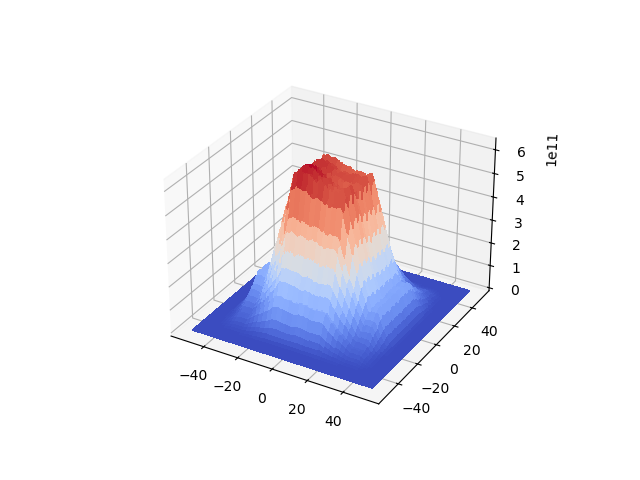

In [18]:
"""YE VARIANCE SHAPE"""

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(xsky, ysky)
surf = ax.plot_surface(X, Y, var_bal.T**2, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

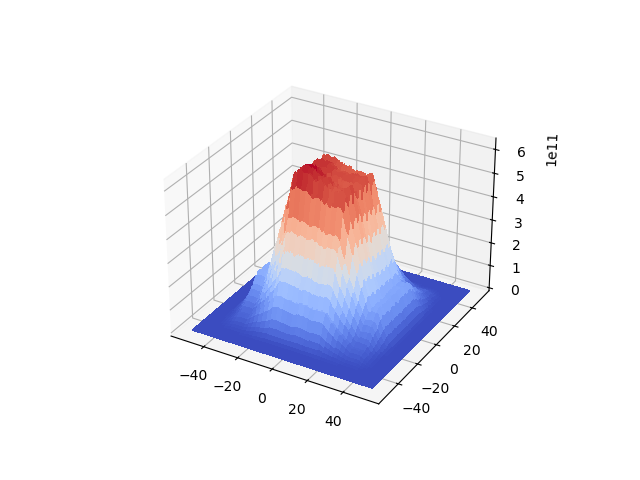

In [19]:
"""FC VARIANCE SHAPE"""

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(xsky, ysky)
surf = ax.plot_surface(X, Y, var_bal_fra.T**2, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

In [20]:
var_bal_clipped =  np.clip(var_bal, a_min=1E-8, a_max=1E8) if np.any(var_bal <= 0) else var_bal
var_bal_clipped_fra =  np.clip(var_bal_fra, a_min=1E-8, a_max=1E8) if np.any(var_bal_fra <= 0) else var_bal_fra

skysign = skyimage/np.sqrt(var_bal_clipped)
skysign_fra = skyimage/np.sqrt(var_bal_clipped_fra)

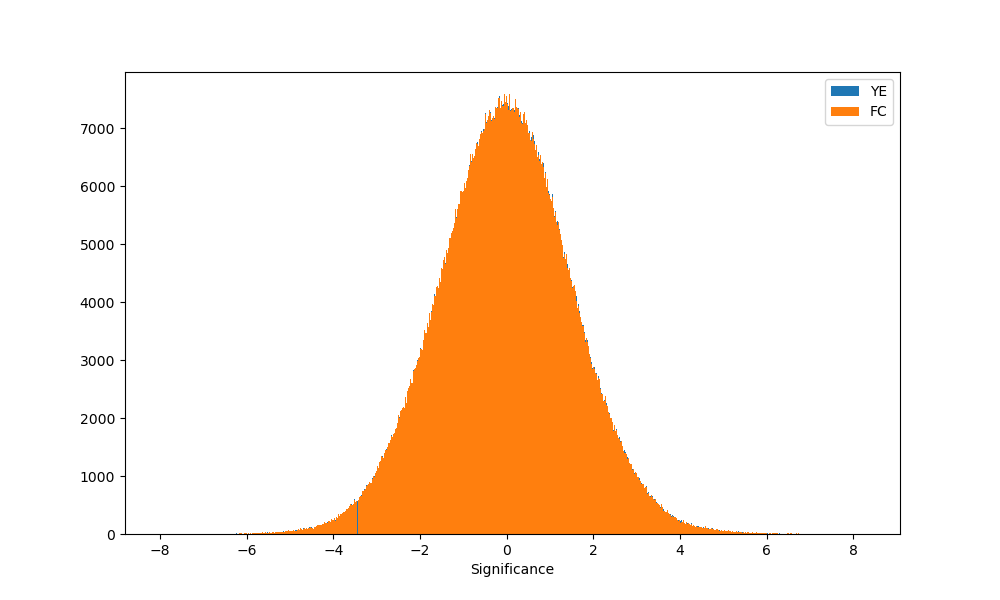

In [21]:
skysign_cut = skysign[204:-204, 133:-133 ]
skysign_cut_fra = skysign_fra[204:-204, 133:-133 ]


plt.figure(figsize=(10, 6), label="Sign")
plt.hist(np.reshape(skysign_cut, shape=skysign_cut.shape[0] * skysign_cut.shape[1]), bins=1000, label="YE")
plt.hist(np.reshape(skysign_cut_fra, shape=skysign_cut_fra.shape[0] * skysign_cut_fra.shape[1]), bins=1000, label="FC")
plt.xlabel("Significance")
plt.legend()
plt.show()

In [22]:
print(np.std(skysign_cut))

1.5442219014610494


0.26327858515288305 -0.029481645238384525 1.5066262548148472


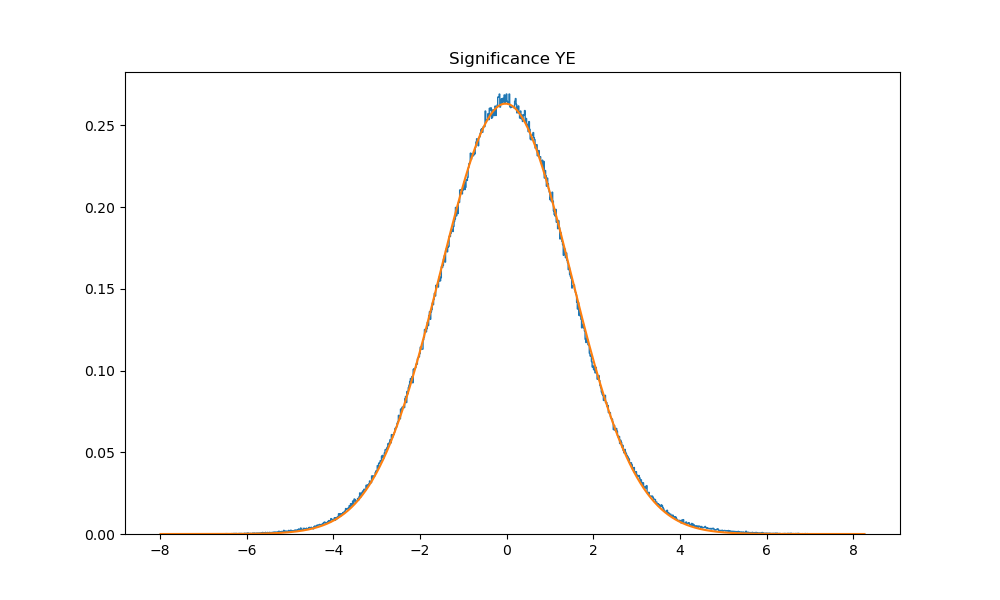

In [23]:
from scipy.optimize import curve_fit
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))


hsign, bins = np.histogram(skysign_cut, bins=1000,  density=True)

binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

popt, pcov = curve_fit(gauss, xdata=binscenters, ydata=hsign, p0=[1, 0, 1.0])
print(*popt)

plt.figure(figsize=(10, 6), label="Sign")
plt.title("Significance YE")
plt.stairs(hsign, bins)
plt.plot(binscenters, gauss(binscenters, *popt))
plt.show()

0.2632602326239473 -0.029476401480151605 1.506721310262752


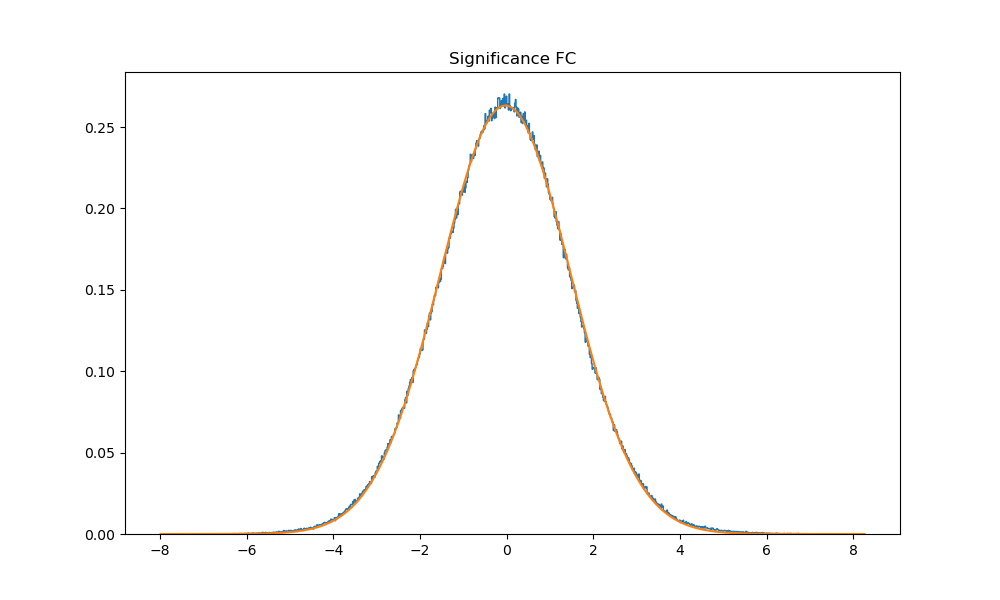

In [24]:
hsign, bins = np.histogram(skysign_cut_fra, bins=1000,  density=True)

binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

popt, pcov = curve_fit(gauss, xdata=binscenters, ydata=hsign, p0=[1, 0, 1.0])
print(*popt)

plt.figure(figsize=(10, 6), label="Sign")
plt.title("Significance FC")
plt.stairs(hsign, bins)
plt.plot(binscenters, gauss(binscenters, *popt))
plt.show()